In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load the data

In [3]:
df = pd.read_excel('../data/Online_Retail.xlsx')

## Show Top 5 Record

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Shape of the Dataset

In [5]:
df.shape

(541909, 8)

## Dataset Information
* InvoiceNo --> Categorical
* StockCode --> Categorical
* Description --> Categorical
* Quantity --> Integer
* Invoice Date --> Date
* UnitPrice --> Continuous
* CustomerID --> Categorical
* Country --> Categorical


## Preprocess the data

In [6]:
# Convert 'InvoiceDate' to datetime format for time-related features

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# Calculate the total bill for each transaction

df['Total_Bill'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Bill
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [8]:
# Aggregate data at Customer Level

customer_df = df.groupby('CustomerID').agg(
    Total_Bill_Size=('Total_Bill', 'sum'),
    Purchase_Interval_Days=('InvoiceDate', lambda x: (x.max() - x.min()).days)
).reset_index()

customer_df.head()

,CustomerID,Total_Bill_Size,Purchase_Interval_Days
0,12346.0,0.00,0
1,12347.0,4310.00,365
2,12348.0,1797.24,282
3,12349.0,1757.55,0
4,12350.0,334.40,0


## Normalize the Features

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(customer_df[['Total_Bill_Size', 'Purchase_Interval_Days']])
print(features)

[[-0.23100099 -1.00418272]
 [ 0.29343167  1.74368485]
 [-0.01231622  1.11882729]
 ...
 [-0.20951263 -0.11583101]
 [ 0.02390005  1.50277591]
 [-0.00744423  0.18530516]]


## Apply DBSCAN

In [10]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(features)


## Add Clusters back to dataframe

In [11]:
customer_df['Cluster'] = clusters

In [12]:
# Display clustering results
print("Cluster counts:")
print(customer_df['Cluster'].value_counts())

Cluster counts:
Cluster
 0    4337
 1      16
-1      12
 2       7
Name: count, dtype: int64


In [13]:
# Identify and display noise points
noise = customer_df[customer_df['Cluster'] == -1]
print(f"Noise points count: {len(noise)}")

Noise points count: 12


## Visualizing results


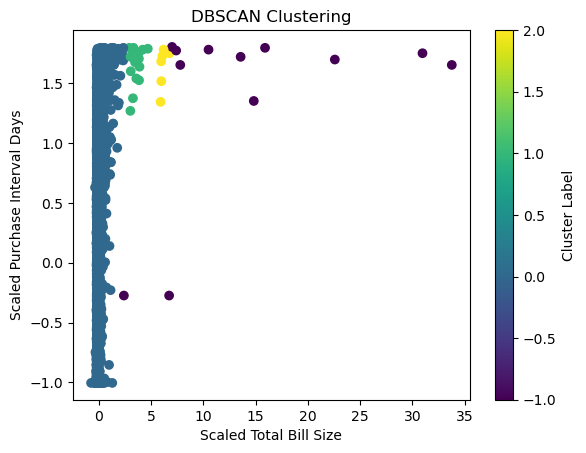

In [14]:
plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Scaled Total Bill Size')
plt.ylabel('Scaled Purchase Interval Days')
plt.colorbar(label='Cluster Label')
plt.show()

## Summary of results


In [15]:
# Summary of results

def summarize_clusters(df):
    grouped = df.groupby('Cluster')
    for key, group in grouped:
        if key == -1:
            continue  # Skip the noise points for detailed summary
        print(f"\nCluster {key} Summary:")
        print(f"Number of Customers: {len(group)}")
        avg_bill = group['Total_Bill_Size'].mean()
        avg_interval = group['Purchase_Interval_Days'].mean()
        print(f"Average Total Bill: {avg_bill:.2f}")
        print(f"Average Purchase Interval: {avg_interval:.2f}")

summarize_clusters(customer_df)


Cluster 0 Summary:
Number of Customers: 4337
Average Total Bill: 1381.65
Average Purchase Interval: 131.72

Cluster 1 Summary:
Number of Customers: 16
Average Total Bill: 30720.77
Average Purchase Interval: 353.69

Cluster 2 Summary:
Number of Customers: 7
Average Total Bill: 52637.10
Average Purchase Interval: 353.00
